# **결론 : 장타율이 높은 타자를 중심타선에 배치하면 추정득점이 증가한다**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager, rc, rcParams
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# 나눔고딕 폰트 다운로드 및 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 나눔고딕 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

# 한글 폰트가 잘 설정되었는지 확인
print(f'Current font: {font}')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# KBO 2023년도

## 데이터전처리

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_2023.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_detail_2023.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_batting_order_2023.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_runner_2023.csv')

# df1
df1_selected = df1[['경기', '선수명', '고의4구', '희생플라이', '희생번트', '득점권타율']]

# df4
df4_selected = df4[['선수명', '도루허용', '도루저지']]

# df3에 df1과 df4의 선택된 컬럼들 병합
df= df3.merge(df1_selected, on='선수명').merge(df4_selected, on='선수명')

# 1루타 열 계산 (안타 - 2루타 - 3루타 - 홈런)
df['1루타'] = df['안타'] - df['2루타'] - df['3루타'] - df['홈런']

# 장타율 열 계산
df['장타율'] = (df['1루타'] + 2*df['2루타'] + 3*df['3루타'] + 4*df['홈런']) / df['타수']

# XR 계산 함수 정의
def calculate_XR(row):
    XR = (row['1루타'] * 0.5 +
          row['2루타'] * 0.72 +
          row['3루타'] * 1.04 +
          row['홈런'] * 1.44 +
          (row['사구'] + row['볼넷'] - row['고의4구']) * 0.34 +
          row['고의4구'] * 0.25 +
          row['도루허용'] * 0.18 -
          row['도루저지'] * 0.32 -
          (row['타수'] - row['안타'] - row['삼진']) * 0.09 -
          row['삼진'] * 0.098 -
          row['병살타'] * 0.37 +
          row['희생플라이'] * 0.37 +
          row['희생번트'] * 0.04)  # 희생번트 값 추가
    return XR

# 각 선수의 XR 계산
df['추정득점'] = df.apply(calculate_XR, axis=1)

# 결과 출력
df

,선수명,팀명,타율,타수,안타,2루타,3루타,홈런,타점,볼넷,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
0,오선우,KIA,0.4,5,2,0,0,1,1,0,...,33,0,0,0,0.5,0,0,1,1.000000,1.662
1,오선우,KIA,-,0,0,0,0,0,0,1,...,33,0,0,0,0.5,0,0,0,NaN,0.340
2,오선우,KIA,0.000,1,0,0,0,0,0,0,...,33,0,0,0,0.5,0,0,0,0.000000,-0.098
3,오선우,KIA,0.000,2,0,0,0,0,0,0,...,33,0,0,0,0.5,0,0,0,0.000000,-0.196
4,오선우,KIA,0.333,9,3,0,0,1,4,0,...,33,0,0,0,0.5,0,0,2,0.666667,1.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,이민준,한화,-,0,0,0,0,0,0,1,...,4,0,0,0,0.0,0,0,0,NaN,0.340
2792,이민준,한화,0.0,1,0,0,0,0,0,0,...,4,0,0,0,0.0,0,0,0,0.000000,-0.090
2793,이민준,한화,0.0,1,0,0,0,0,0,1,...,4,0,0,0,0.0,0,0,0,0.000000,0.250
2794,이상혁,한화,0.0,2,0,0,0,0,0,0,...,7,0,0,0,0.0,1,1,0,0.000000,-0.328


In [ ]:
game_mean = df['경기'].mean()
bats_mean = df['타수'].mean()
KBO_2023 = df[(df['경기'] >= game_mean) & (df['타수'] >= bats_mean)]
KBO_2023.drop(columns=['타율'], axis=1, inplace=True)

KBO_2023

<ipython-input-31-8109c6043dd7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBO_2023.drop(columns=['타율'], axis=1, inplace=True)


,선수명,팀명,타수,안타,2루타,3루타,홈런,타점,볼넷,사구,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
17,김규성,KIA,107,28,3,0,2,9,8,0,...,99,0,0,5,0.178,6,2,23,0.345794,11.842
20,김규성,KIA,146,34,6,0,2,11,10,1,...,99,0,0,5,0.178,6,2,26,0.315068,13.440
31,박찬호,KIA,154,48,5,1,1,17,10,1,...,130,0,6,7,0.355,30,8,41,0.376623,23.748
32,박찬호,KIA,128,39,6,2,1,16,13,1,...,130,0,6,7,0.355,30,8,30,0.406250,24.086
34,박찬호,KIA,157,46,6,1,1,19,16,0,...,130,0,6,7,0.355,30,8,38,0.363057,24.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,노시환,한화,499,153,30,1,31,101,72,4,...,131,5,3,0,0.299,2,1,91,0.557114,102.844
2754,채은성,한화,110,30,4,0,6,14,10,4,...,137,8,3,0,0.311,0,0,20,0.472727,17.066
2755,채은성,한화,363,94,11,0,14,62,38,12,...,137,8,3,0,0.311,0,0,69,0.404959,51.846
2756,채은성,한화,40,10,2,0,2,5,4,3,...,137,8,3,0,0.311,0,0,6,0.450000,6.980


In [ ]:
KBO_2023.isnull().sum() # 모든컬럼에 결측치 없음 확인

선수명      0
팀명       0
타수       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
볼넷       0
사구       0
삼진       0
병살타      0
타순       0
경기       0
고의4구     0
희생플라이    0
희생번트     0
득점권타율    0
도루허용     0
도루저지     0
1루타      0
장타율      0
추정득점     0
dtype: int64

## 상위타순

In [ ]:
# '타순' 열의 값이 '1번', '2번', '상위(1~2번)'인 행만 선택
table_batters = KBO_2023[KBO_2023['타순'].isin(['1번', '2번'])]

# 결과 확인
print(table_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_table = table_batters.nlargest(8, '장타율')

top_avg_players_table.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_table)

top_avg_players_table['추정득점'].mean()

(75, 23)


19.380499999999998

In [ ]:
print(top_avg_players_table['장타율'].mean())
top_avg_players_table

0.5507996990235938


,선수명,팀명,타수,타순,경기,장타율,추정득점
1082,오태곤,SSG,49,1번,123,0.693878,16.412
1770,전준우,롯데,44,2번,138,0.568182,13.260
2203,김혜성,키움,90,1번,137,0.566667,25.768
1911,구자욱,삼성,67,1번,119,0.552239,16.534
2712,윌리엄스,한화,72,2번,68,0.527778,11.544
38,김도영,KIA,199,2번,84,0.522613,41.422
1796,안치홍,롯데,59,2번,121,0.491525,12.300
390,강백호,KT,91,2번,71,0.483516,17.804


In [ ]:
# 타순이 1번인 선수들 선택
first_batters = top_avg_players_table[top_avg_players_table['타순'] == '1번']

# 타순이 2번인 선수들 선택
second_batters = top_avg_players_table[top_avg_players_table['타순'] == '2번']

# 결과 출력
print("타순 1번인 선수들:")
display(first_batters)

print("\n타순 2번인 선수들:" )
display(second_batters)

print(first_batters['추정득점'].mean(), second_batters['추정득점'].mean())
print(first_batters['장타율'].mean(), second_batters['장타율'].mean())

타순 1번인 선수들:


,선수명,팀명,타수,타순,경기,장타율,추정득점
1082,오태곤,SSG,49,1번,123,0.693878,16.412
2203,김혜성,키움,90,1번,137,0.566667,25.768
1911,구자욱,삼성,67,1번,119,0.552239,16.534



타순 2번인 선수들:


,선수명,팀명,타수,타순,경기,장타율,추정득점
1770,전준우,롯데,44,2번,138,0.568182,13.260
2712,윌리엄스,한화,72,2번,68,0.527778,11.544
38,김도영,KIA,199,2번,84,0.522613,41.422
1796,안치홍,롯데,59,2번,121,0.491525,12.300
390,강백호,KT,91,2번,71,0.483516,17.804


19.57133333333333 19.266
0.6042610078857414 0.5187229137063053


## 중심타순

In [ ]:
# '타순' 열의 값이 '3번', '4번', '5번', '중심(3~5번)'인 행만 선택
center_batters = KBO_2023[KBO_2023['타순'].isin(['3번', '4번', '5번'])]

# 결과 확인
print(center_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_center = center_batters.nlargest(10, '장타율')

top_avg_players_center.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_center)

top_avg_players_center['추정득점'].mean()

(102, 23)


42.5128

In [ ]:
print(top_avg_players_center['장타율'].mean())
top_avg_players_center

0.58776542410297


,선수명,팀명,타수,타순,경기,장타율,추정득점
254,알포드,KT,49,5번,133,0.693878,14.680
1184,에레디아,SSG,41,5번,122,0.658537,10.780
1710,정훈,롯데,55,3번,80,0.636364,13.646
2298,이주형,키움,55,5번,69,0.636364,12.496
1548,양의지,두산,87,3번,129,0.574713,23.094
1283,최정,SSG,399,3번,128,0.571429,85.840
2749,노시환,한화,438,3번,131,0.552511,88.138
1924,피렐라,삼성,139,5번,139,0.525180,27.192
829,오스틴,LG,514,4번,139,0.519455,96.000
1772,전준우,롯데,271,4번,138,0.509225,53.262


## 하위타순

In [ ]:
# '타순' 열의 값이 '6번', '7번', '8번','9번' '하위(6~9번)'인 행만 선택
low_batters = KBO_2023[KBO_2023['타순'].isin(['6번', '7번', '8번','9번'])]

# 결과 확인
print(low_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_low = low_batters.nlargest(16, '장타율')

top_avg_players_low.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_low)

top_avg_players_low['추정득점'].mean()

(159, 23)


15.198625

In [ ]:
print(top_avg_players_low['장타율'].mean())
top_avg_players_low

0.5645343042196895


,선수명,팀명,타수,타순,경기,장타율,추정득점
1100,하재훈,SSG,46,7번,77,0.739130,15.408
1980,이재현,삼성,87,8번,143,0.620690,23.130
1828,유강남,롯데,50,6번,121,0.620000,12.990
1558,양석환,두산,47,6번,140,0.617021,13.992
1150,최주환,SSG,44,6번,134,0.613636,10.344
516,이호연,KT,57,6번,85,0.561404,11.718
221,문상철,KT,42,7번,112,0.547619,9.608
487,오윤석,KT,83,7번,82,0.542169,15.202
527,장성우,KT,83,6번,131,0.542169,20.290
181,소크라테스,KIA,91,6번,142,0.538462,21.256


# KBO 2022년도

## 데이터전처리

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_2022.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_detail_2022.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_batting_order_2022.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_runner_2022.csv')

# df1
df1_selected = df1[['경기', '선수명', '고의4구', '희생플라이', '희생번트', '득점권타율']]

# df4
df4_selected = df4[['선수명', '도루허용', '도루저지']]

# df3에 df1과 df4의 선택된 컬럼들 병합
df= df3.merge(df1_selected, on='선수명').merge(df4_selected, on='선수명')

# 1루타 열 계산 (안타 - 2루타 - 3루타 - 홈런)
df['1루타'] = df['안타'] - df['2루타'] - df['3루타'] - df['홈런']

# 장타율 열 계산
df['장타율'] = (df['1루타'] + 2*df['2루타'] + 3*df['3루타'] + 4*df['홈런']) / df['타수']

# XR 계산 함수 정의
def calculate_XR(row):
    XR = (row['1루타'] * 0.5 +
          row['2루타'] * 0.72 +
          row['3루타'] * 1.04 +
          row['홈런'] * 1.44 +
          (row['사구'] + row['볼넷'] - row['고의4구']) * 0.34 +
          row['고의4구'] * 0.25 +
          row['도루허용'] * 0.18 -
          row['도루저지'] * 0.32 -
          (row['타수'] - row['안타'] - row['삼진']) * 0.09 -
          row['삼진'] * 0.098 -
          row['병살타'] * 0.37 +
          row['희생플라이'] * 0.37 +
          row['희생번트'] * 0.04)  # 희생번트 값 추가
    return XR

# 각 선수의 XR 계산
df['추정득점'] = df.apply(calculate_XR, axis=1)

# 결과 출력
df

,선수명,팀명,타율,타수,안타,2루타,3루타,홈런,타점,볼넷,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
0,김호령,KIA,1.0,1,1,0,0,0,0,0,...,54,0,0,4,0.222,2,1,1,1.000000,0.700
1,김호령,KIA,0.286,7,2,0,0,1,4,1,...,54,0,0,4,0.222,2,1,1,0.714286,1.644
2,김호령,KIA,0.0,2,0,0,0,0,0,0,...,54,0,0,4,0.222,2,1,0,0.000000,0.004
3,김호령,KIA,1.0,1,1,1,0,0,0,0,...,54,0,0,4,0.222,2,1,0,2.000000,0.920
4,김호령,KIA,0.0,4,0,0,0,0,0,0,...,54,0,0,4,0.222,2,1,0,0.000000,-0.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,백용환,한화,0.500,2,1,1,0,0,0,0,...,4,0,0,0,0.000,0,0,0,1.000000,0.630
2662,백용환,한화,0.0,1,0,0,0,0,0,0,...,4,0,0,0,0.000,0,0,0,0.000000,-0.098
2663,백용환,한화,0.0,2,0,0,0,0,0,0,...,4,0,0,0,0.000,0,0,0,0.000000,-0.180
2664,백용환,한화,0.5,2,1,1,0,0,0,0,...,4,0,0,0,0.000,0,0,0,1.000000,0.630


In [ ]:
game_mean = df['경기'].mean()
bats_mean = df['타수'].mean()
KBO_2022 = df[(df['경기'] >= game_mean) & (df['타수'] >= bats_mean)]
KBO_2022.drop(columns=['타율'], axis=1, inplace=True)

KBO_2022

<ipython-input-10-3560a7d1dff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBO_2022.drop(columns=['타율'], axis=1, inplace=True)


,선수명,팀명,타수,안타,2루타,3루타,홈런,타점,볼넷,사구,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
35,류지혁,KIA,168,54,8,0,1,20,31,2,...,127,0,2,8,0.305,8,4,45,0.386905,30.876
41,류지혁,KIA,54,18,3,0,0,9,3,1,...,127,0,2,8,0.305,8,4,15,0.388889,8.936
43,류지혁,KIA,138,29,6,1,0,13,15,0,...,127,0,2,8,0.305,8,4,22,0.268116,11.512
44,류지혁,KIA,176,56,8,0,1,20,33,2,...,127,0,2,8,0.305,8,4,47,0.380682,31.638
46,류지혁,KIA,225,55,11,2,1,28,23,4,...,127,0,2,8,0.305,8,4,41,0.324444,25.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,김인환,한화,98,18,6,0,1,7,6,0,...,113,2,4,0,0.203,2,0,11,0.275510,7.142
2636,하주석,한화,233,53,7,0,1,26,18,2,...,125,1,3,1,0.255,20,6,45,0.270386,21.004
2637,하주석,한화,164,49,10,2,3,23,7,0,...,125,1,3,1,0.255,20,6,34,0.439024,24.680
2642,하주석,한화,237,54,7,0,1,27,18,2,...,125,1,3,1,0.255,20,6,46,0.270042,21.218


In [ ]:
KBO_2022.isnull().sum() # 모든컬럼에 결측치 없음 확인

선수명      0
팀명       0
타수       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
볼넷       0
사구       0
삼진       0
병살타      0
타순       0
경기       0
고의4구     0
희생플라이    0
희생번트     0
득점권타율    0
도루허용     0
도루저지     0
1루타      0
장타율      0
추정득점     0
dtype: int64

## 상위타순

In [ ]:
# '타순' 열의 값이 '1번', '2번', '상위(1~2번)'인 행만 선택
table_batters = KBO_2022[KBO_2022['타순'].isin(['1번', '2번'])]

# 결과 확인
print(table_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_table = table_batters.nlargest(12, '장타율')

top_avg_players_table.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_table)

top_avg_players_table['추정득점'].mean()

(64, 23)


32.86633333333333

## 중위타순

In [ ]:
# '타순' 열의 값이 '3번', '4번', '5번', '중심(3~5번)'인 행만 선택
center_batters = KBO_2022[KBO_2022['타순'].isin(['3번', '4번', '5번'])]

# 결과 확인
print(center_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_center = center_batters.nlargest(15, '장타율')

top_avg_players_center.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_center)

top_avg_players_center['추정득점'].mean()

(90, 23)


45.652000000000015

## 하위타순

In [ ]:
# '타순' 열의 값이 '6번', '7번', '8번','9번' '하위(6~9번)'인 행만 선택
low_batters = KBO_2022[KBO_2022['타순'].isin(['6번', '7번', '8번','9번'])]

# 결과 확인
print(low_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_low = low_batters.nlargest(12, '장타율')

top_avg_players_low.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_low)

top_avg_players_low['추정득점'].mean()

(157, 23)


16.159000000000002

# KBO 2021년도

## 데이터전처리

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_2021.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_detail_2021.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_batting_order_2021.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_runner_2021.csv')

# df1
df1_selected = df1[['경기', '선수명', '고의4구', '희생플라이', '희생번트', '득점권타율']]

# df4
df4_selected = df4[['선수명', '도루허용', '도루저지']]

# df3에 df1과 df4의 선택된 컬럼들 병합
df= df3.merge(df1_selected, on='선수명').merge(df4_selected, on='선수명')

# 1루타 열 계산 (안타 - 2루타 - 3루타 - 홈런)
df['1루타'] = df['안타'] - df['2루타'] - df['3루타'] - df['홈런']

# 장타율 열 계산
df['장타율'] = (df['1루타'] + 2*df['2루타'] + 3*df['3루타'] + 4*df['홈런']) / df['타수']

# XR 계산 함수 정의
def calculate_XR(row):
    XR = (row['1루타'] * 0.5 +
          row['2루타'] * 0.72 +
          row['3루타'] * 1.04 +
          row['홈런'] * 1.44 +
          (row['사구'] + row['볼넷'] - row['고의4구']) * 0.34 +
          row['고의4구'] * 0.25 +
          row['도루허용'] * 0.18 -
          row['도루저지'] * 0.32 -
          (row['타수'] - row['안타'] - row['삼진']) * 0.09 -
          row['삼진'] * 0.098 -
          row['병살타'] * 0.37 +
          row['희생플라이'] * 0.37 +
          row['희생번트'] * 0.04)  # 희생번트 값 추가
    return XR

# 각 선수의 XR 계산
df['추정득점'] = df.apply(calculate_XR, axis=1)

# 결과 출력
df

,선수명,팀명,타율,타수,안타,2루타,3루타,홈런,타점,볼넷,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
0,이우성,KIA,1.0,1,1,0,0,0,0,0,...,60,0,2,1,0.239,2,1,1,1.000000,1.320
1,이우성,KIA,0.5,2,1,0,0,0,0,0,...,60,0,2,1,0.239,2,1,1,0.500000,1.230
2,이우성,KIA,0.6,5,3,0,0,0,2,1,...,60,0,2,1,0.239,2,1,3,0.600000,2.472
3,이우성,KIA,0.129,31,4,2,0,0,0,5,...,60,0,2,1,0.239,2,1,2,0.193548,2.120
4,이우성,KIA,0.25,28,7,3,0,0,0,4,...,60,0,2,1,0.239,2,1,4,0.357143,4.394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,노시환,한화,0.242,264,64,9,0,9,40,51,...,91,0,1,1,0.205,5,2,46,0.378788,38.490
1871,노시환,한화,0.326,86,28,6,0,6,28,11,...,91,0,1,1,0.205,5,2,16,0.604651,19.226
1872,노시환,한화,0.407,27,11,3,1,3,16,11,...,91,0,1,1,0.205,5,2,4,0.925926,11.324
1873,노시환,한화,0.261,353,92,15,0,15,68,62,...,91,0,1,1,0.205,5,2,62,0.430595,56.760


In [ ]:
game_mean = df['경기'].mean()
bats_mean = df['타수'].mean()
KBO_2021 = df[(df['경기'] >= game_mean) & (df['타수'] >= bats_mean)]
KBO_2021.drop(columns=['타율'], axis=1, inplace=True)

KBO_2021

<ipython-input-16-5e2346f5c3a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBO_2021.drop(columns=['타율'], axis=1, inplace=True)


,선수명,팀명,타수,안타,2루타,3루타,홈런,타점,볼넷,사구,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
16,이창진,KIA,65,16,4,1,1,14,10,0,...,133,0,5,4,0.267,5,0,10,0.384615,11.432
17,이창진,KIA,83,18,1,0,1,9,11,1,...,133,0,5,4,0.267,5,0,16,0.265060,9.282
21,이창진,KIA,194,44,6,1,3,27,29,1,...,133,0,5,4,0.267,5,0,34,0.314433,22.246
23,김태진,KIA,59,21,0,0,0,4,7,0,...,123,0,3,5,0.296,8,5,21,0.355932,9.404
24,김태진,KIA,137,28,6,2,0,9,9,0,...,123,0,3,5,0.296,8,5,20,0.277372,9.868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,최재훈,한화,303,87,20,0,6,39,58,12,...,135,0,4,4,0.225,3,2,61,0.412541,54.150
1852,최재훈,한화,71,16,1,0,1,5,14,0,...,135,0,4,4,0.225,3,2,14,0.281690,9.336
1870,노시환,한화,264,64,9,0,9,40,51,1,...,91,0,1,1,0.205,5,2,46,0.378788,38.490
1871,노시환,한화,86,28,6,0,6,28,11,0,...,91,0,1,1,0.205,5,2,16,0.604651,19.226


In [ ]:
KBO_2021.isnull().sum() # 모든컬럼에 결측치 없음 확인

선수명      0
팀명       0
타수       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
볼넷       0
사구       0
삼진       0
병살타      0
타순       0
경기       0
고의4구     0
희생플라이    0
희생번트     0
득점권타율    0
도루허용     0
도루저지     0
1루타      0
장타율      0
추정득점     0
dtype: int64

## 상위타순

In [ ]:
# '타순' 열의 값이 '1번', '2번', '상위(1~2번)'인 행만 선택
table_batters = KBO_2021[KBO_2021['타순'].isin(['1번', '2번'])]

# 결과 확인
print(table_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_table = table_batters.nlargest(8, '장타율')

top_avg_players_table.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_table)

top_avg_players_table['추정득점'].mean()

(42, 23)


24.974999999999998

## 중심타순

In [ ]:
# '타순' 열의 값이 '3번', '4번', '5번', '중심(3~5번)'인 행만 선택
center_batters = KBO_2021[KBO_2021['타순'].isin(['3번', '4번', '5번'])]

# 결과 확인
print(center_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_center = center_batters.nlargest(10, '장타율')

top_avg_players_center.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_center)

top_avg_players_center['추정득점'].mean()

(57, 23)


55.09920000000001

## 하위타순

In [ ]:
# '타순' 열의 값이 '6번', '7번', '8번','9번' '하위(6~9번)'인 행만 선택
low_batters = KBO_2021[KBO_2021['타순'].isin(['6번', '7번', '8번','9번'])]

# 결과 확인
print(low_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_low = low_batters.nlargest(6, '장타율')

top_avg_players_low.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_low)

top_avg_players_low['추정득점'].mean()

(75, 23)


14.408

# KBO 2020년도

## 데이터전처리

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_2020.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_detail_2020.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_batting_order_2020.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_runner_2020.csv')

# df1
df1_selected = df1[['경기', '선수명', '고의4구', '희생플라이', '희생번트', '득점권타율']]

# df4
df4_selected = df4[['선수명', '도루허용', '도루저지']]

# df3에 df1과 df4의 선택된 컬럼들 병합
df= df3.merge(df1_selected, on='선수명').merge(df4_selected, on='선수명')

# 1루타 열 계산 (안타 - 2루타 - 3루타 - 홈런)
df['1루타'] = df['안타'] - df['2루타'] - df['3루타'] - df['홈런']

# 장타율 열 계산
df['장타율'] = (df['1루타'] + 2*df['2루타'] + 3*df['3루타'] + 4*df['홈런']) / df['타수']

# XR 계산 함수 정의
def calculate_XR(row):
    XR = (row['1루타'] * 0.5 +
          row['2루타'] * 0.72 +
          row['3루타'] * 1.04 +
          row['홈런'] * 1.44 +
          (row['사구'] + row['볼넷'] - row['고의4구']) * 0.34 +
          row['고의4구'] * 0.25 +
          row['도루허용'] * 0.18 -
          row['도루저지'] * 0.32 -
          (row['타수'] - row['안타'] - row['삼진']) * 0.09 -
          row['삼진'] * 0.098 -
          row['병살타'] * 0.37 +
          row['희생플라이'] * 0.37 +
          row['희생번트'] * 0.04)  # 희생번트 값 추가
    return XR

# 각 선수의 XR 계산
df['추정득점'] = df.apply(calculate_XR, axis=1)

# 결과 출력
df

,선수명,팀명,타율,타수,안타,2루타,3루타,홈런,타점,볼넷,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
0,고장혁,KIA,0.500,2,1,0,0,0,0,0,...,22,0,0,0,0.2,0,0,1,0.500000,0.402
1,고장혁,KIA,1.0,1,1,0,0,0,0,0,...,22,0,0,0,0.2,0,0,1,1.000000,0.500
2,고장혁,KIA,0.125,8,1,0,0,0,0,0,...,22,0,0,0,0.2,0,0,1,0.125000,-0.154
3,고장혁,KIA,0.0,2,0,0,0,0,0,0,...,22,0,0,0,0.2,0,0,0,0.000000,-0.188
4,고장혁,KIA,0.500,2,1,0,0,0,0,0,...,22,0,0,0,0.2,0,0,1,0.500000,0.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,최승준,한화,0.0,1,0,0,0,0,0,0,...,10,0,0,0,0.0,0,0,0,0.000000,-0.098
2060,박한결,한화,0.667,3,2,0,0,0,1,0,...,9,0,0,0,0.0,0,0,2,0.666667,0.910
2061,박한결,한화,0.0,3,0,0,0,0,0,0,...,9,0,0,0,0.0,0,0,0,0.000000,-0.656
2062,박한결,한화,0.071,14,1,0,0,0,0,2,...,9,0,0,0,0.0,0,0,1,0.071429,-0.408


In [ ]:
game_mean = df['경기'].mean()
bats_mean = df['타수'].mean()
KBO_2020 = df[(df['경기'] >= game_mean) & (df['타수'] >= bats_mean)]
KBO_2020.drop(columns=['타율'], axis=1, inplace=True)

KBO_2020

<ipython-input-22-712b95359f34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBO_2020.drop(columns=['타율'], axis=1, inplace=True)


,선수명,팀명,타수,안타,2루타,3루타,홈런,타점,볼넷,사구,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
7,김선빈,KIA,239,73,12,0,1,29,33,1,...,121,0,4,5,0.297,1,1,60,0.368201,33.874
13,김선빈,KIA,273,90,17,0,1,35,34,2,...,121,0,4,5,0.297,1,1,72,0.402930,42.608
19,김태진,KIA,79,18,1,0,0,6,3,0,...,123,0,3,5,0.296,7,4,17,0.240506,5.896
20,김태진,KIA,57,13,2,0,0,7,4,1,...,123,0,3,5,0.296,7,4,11,0.263158,5.946
21,김태진,KIA,52,13,1,0,0,2,2,0,...,123,0,3,5,0.296,7,4,12,0.269231,4.738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,호잉,한화,72,16,2,0,3,13,4,0,...,124,5,5,1,0.262,5,3,11,0.375000,7.714
2030,호잉,한화,109,22,3,0,4,14,7,0,...,124,5,5,1,0.262,5,3,15,0.339450,9.638
2049,김태균,한화,97,22,7,0,0,15,11,1,...,127,5,8,0,0.301,0,0,15,0.298969,11.086
2054,김태균,한화,174,38,10,0,2,26,22,1,...,127,5,8,0,0.301,0,0,26,0.310345,19.032


In [ ]:
KBO_2020.isnull().sum() # 모든컬럼에 결측치 없음 확인

선수명      0
팀명       0
타수       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
볼넷       0
사구       0
삼진       0
병살타      0
타순       0
경기       0
고의4구     0
희생플라이    0
희생번트     0
득점권타율    0
도루허용     0
도루저지     0
1루타      0
장타율      0
추정득점     0
dtype: int64

## 상위타순

In [ ]:
# '타순' 열의 값이 '1번', '2번', '상위(1~2번)'인 행만 선택
table_batters = KBO_2020[KBO_2020['타순'].isin(['1번', '2번'])]

# 결과 확인
print(table_batters.shape)

# 선수명 중복 제거
unique_batters = table_batters.drop_duplicates(subset='선수명')

# 장타율 상위 8명 선택
top_avg_players_table = unique_batters.nlargest(8, '장타율')

top_avg_players_table.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_table)

top_avg_players_table['추정득점'].mean()

(47, 23)


49.50275

In [ ]:
top_avg_players_table

,선수명,팀명,타수,타순,경기,장타율,추정득점
98,터커,KIA,278,2번,95,0.575540,63.620
466,김현수,LG,157,2번,140,0.566879,34.138
237,황재균,KT,375,2번,124,0.541333,72.574
1778,김하성,키움,385,2번,139,0.524675,83.950
1190,페르난데스,두산,429,2번,144,0.519814,82.908
1259,오윤석,롯데,66,1번,76,0.515152,13.350
1087,허경민,두산,94,1번,133,0.510638,24.062
824,오태곤,SK,115,2번,123,0.486957,21.420


## 중심타순

In [ ]:
# '타순' 열의 값이 '3번', '4번', '5번', '중심(3~5번)'인 행만 선택
center_batters = KBO_2020[KBO_2020['타순'].isin(['3번', '4번', '5번'])]

# 결과 확인
print(center_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_center = center_batters.nlargest(10, '장타율')

top_avg_players_center.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_center)

top_avg_players_center['추정득점'].mean()

(58, 23)


44.0294

In [ ]:
top_avg_players_center

,선수명,팀명,타수,타순,경기,장타율,추정득점
326,로하스,KT,86,5번,142,0.709302,24.032
325,로하스,KT,64,4번,142,0.687500,15.244
324,로하스,KT,392,3번,142,0.673469,96.166
889,로맥,SK,67,5번,137,0.641791,19.362
156,최형우,KIA,230,4번,136,0.617391,59.342
570,양의지,NC,432,4번,118,0.601852,96.120
333,강백호,KT,90,3번,116,0.600000,21.764
392,이형종,LG,108,5번,120,0.592593,24.960
359,유한준,KT,95,4번,139,0.578947,22.814
155,최형우,KIA,272,3번,136,0.573529,60.490


## 하위타순

In [ ]:
# '타순' 열의 값이 '6번', '7번', '8번','9번' '하위(6~9번)'인 행만 선택
low_batters = KBO_2020[KBO_2020['타순'].isin(['6번', '7번', '8번','9번'])]

# 결과 확인
print(low_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_low = low_batters.nlargest(7, '장타율')

top_avg_players_low.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_low)

top_avg_players_low['추정득점'].mean()

(82, 23)


21.825714285714287

# KBO 2019년도

## 데이터전처리

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_2019.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_hitter_detail_2019.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_batting_order_2019.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DATATHON/data/@KBO_10개구단/KBO_runner_2019.csv')

# df1
df1_selected = df1[['경기', '선수명', '고의4구', '희생플라이', '희생번트', '득점권타율']]

# df4
df4_selected = df4[['선수명', '도루허용', '도루저지']]

# df3에 df1과 df4의 선택된 컬럼들 병합
df= df3.merge(df1_selected, on='선수명').merge(df4_selected, on='선수명')

# 1루타 열 계산 (안타 - 2루타 - 3루타 - 홈런)
df['1루타'] = df['안타'] - df['2루타'] - df['3루타'] - df['홈런']

# 장타율 열 계산
df['장타율'] = (df['1루타'] + 2*df['2루타'] + 3*df['3루타'] + 4*df['홈런']) / df['타수']

# XR 계산 함수 정의
def calculate_XR(row):
    XR = (row['1루타'] * 0.5 +
          row['2루타'] * 0.72 +
          row['3루타'] * 1.04 +
          row['홈런'] * 1.44 +
          (row['사구'] + row['볼넷'] - row['고의4구']) * 0.34 +
          row['고의4구'] * 0.25 +
          row['도루허용'] * 0.18 -
          row['도루저지'] * 0.32 -
          (row['타수'] - row['안타'] - row['삼진']) * 0.09 -
          row['삼진'] * 0.098 -
          row['병살타'] * 0.37 +
          row['희생플라이'] * 0.37 +
          row['희생번트'] * 0.04)  # 희생번트 값 추가
    return XR

# 각 선수의 XR 계산
df['추정득점'] = df.apply(calculate_XR, axis=1)

# 결과 출력
df

,선수명,팀명,타율,타수,안타,2루타,3루타,홈런,타점,볼넷,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
0,이우성,KIA,0.500,4,2,0,0,0,1,1,...,60,0,2,1,0.239,0,0,2,0.500000,1.932
1,이우성,KIA,0.500,4,2,2,0,0,0,0,...,60,0,2,1,0.239,0,0,0,1.000000,2.040
2,이우성,KIA,0.5,6,3,1,0,0,2,1,...,60,0,2,1,0.239,0,0,2,0.666667,2.562
3,이우성,KIA,0.25,8,2,0,0,0,0,0,...,60,0,2,1,0.239,0,0,2,0.250000,1.224
4,이우성,KIA,0.136,22,3,0,0,2,5,2,...,60,0,2,1,0.239,0,0,1,0.409091,2.704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,김창혁,한화,0.000,1,0,0,0,0,0,0,...,3,0,0,0,0.000,0,0,0,0.000000,-0.098
2405,김창혁,한화,0.000,1,0,0,0,0,0,0,...,3,0,0,0,0.000,0,0,0,0.000000,-0.090
2406,김창혁,한화,0.0,2,0,0,0,0,0,0,...,3,0,0,0,0.000,0,0,0,0.000000,-0.188
2407,박준혁,한화,0.000,2,0,0,0,0,0,0,...,4,0,0,0,0.000,0,0,0,0.000000,-0.188


In [ ]:
game_mean = df['경기'].mean()
bats_mean = df['타수'].mean()
KBO_2019 = df[(df['경기'] >= game_mean) & (df['타수'] >= bats_mean)]
KBO_2019.drop(columns=['타율'], axis=1, inplace=True)

KBO_2019

<ipython-input-30-f0d084b46a7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBO_2019.drop(columns=['타율'], axis=1, inplace=True)


,선수명,팀명,타수,안타,2루타,3루타,홈런,타점,볼넷,사구,...,경기,고의4구,희생플라이,희생번트,득점권타율,도루허용,도루저지,1루타,장타율,추정득점
24,터커,KIA,315,97,28,0,8,44,29,2,...,95,0,1,0,0.293,0,0,61,0.473016,48.742
30,터커,KIA,350,107,32,0,9,48,34,3,...,95,0,1,0,0.293,0,0,66,0.474286,55.288
32,김주찬,KIA,105,34,9,0,1,10,9,0,...,100,3,3,1,0.250,3,1,24,0.438095,17.570
36,김주찬,KIA,111,31,4,0,0,11,3,1,...,100,3,3,1,0.250,3,1,27,0.315315,10.040
37,김주찬,KIA,50,14,1,0,2,4,3,2,...,100,3,3,1,0.250,3,1,11,0.420000,8.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,송광민,한화,292,76,11,0,5,33,15,2,...,122,0,5,3,0.261,8,2,60,0.349315,30.034
2343,송광민,한화,133,39,7,0,2,16,4,1,...,122,0,5,3,0.261,8,2,30,0.390977,16.164
2373,최재훈,한화,134,36,7,0,1,14,22,5,...,135,0,4,4,0.225,3,10,28,0.343284,18.896
2374,최재훈,한화,184,55,8,0,1,12,29,7,...,135,0,4,4,0.225,3,10,46,0.358696,27.358


In [ ]:
KBO_2019.isnull().sum() # 모든컬럼에 결측치 없음 확인

선수명      0
팀명       0
타수       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
볼넷       0
사구       0
삼진       0
병살타      0
타순       0
경기       0
고의4구     0
희생플라이    0
희생번트     0
득점권타율    0
도루허용     0
도루저지     0
1루타      0
장타율      0
추정득점     0
dtype: int64

## 상위타순

In [ ]:
# '타순' 열의 값이 '1번', '2번', '상위(1~2번)'인 행만 선택
table_batters = KBO_2019[KBO_2019['타순'].isin(['1번', '2번'])]

# 결과 확인
print(table_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_table = table_batters.nlargest(10, '장타율')

top_avg_players_table.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_table)

top_avg_players_table['추정득점'].mean()

(54, 23)


33.218399999999995

## 중심타순

In [ ]:
# '타순' 열의 값이 '3번', '4번', '5번', '중심(3~5번)'인 행만 선택
center_batters = KBO_2019[KBO_2019['타순'].isin(['3번', '4번', '5번'])]

# 결과 확인
print(center_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_center = center_batters.nlargest(14, '장타율')

top_avg_players_center.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_center)

top_avg_players_center['추정득점'].mean()

(86, 23)


38.244571428571426

## 하위타순

In [ ]:
# '타순' 열의 값이 '6번', '7번', '8번','9번' '하위(6~9번)'인 행만 선택
low_batters = KBO_2019[KBO_2019['타순'].isin(['6번', '7번', '8번','9번'])]

# 결과 확인
print(low_batters.shape)

# 득점권 타율이 높은 선수  선택
top_avg_players_low = low_batters.nlargest(9, '장타율')

top_avg_players_low.drop(['안타', '2루타', '3루타', '홈런', '타점', '볼넷', '사구',
                '삼진', '병살타', '고의4구', '희생플라이', '희생번트','도루허용',
                '도루저지', '득점권타율', '1루타'], axis=1, inplace=True)
# display(top_avg_players_low)

top_avg_players_low['추정득점'].mean()

(116, 23)


17.029777777777777

# 연도별 시각화 (바그래프)

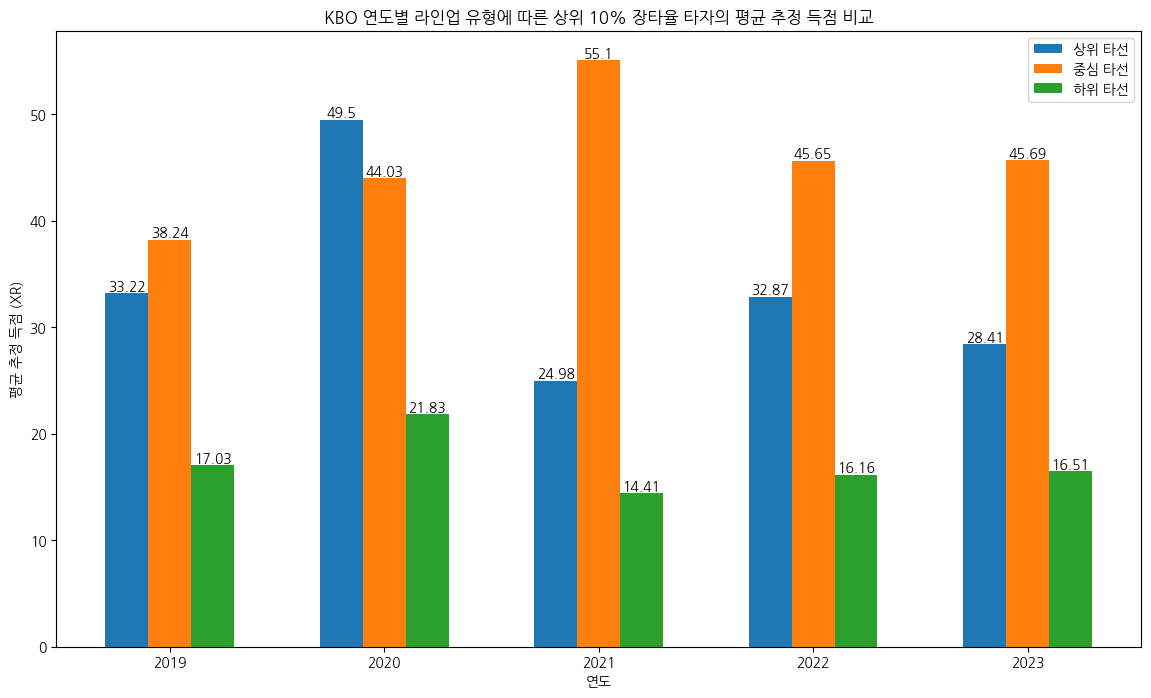

In [ ]:
detailed_user_provided_data = {
    2019: {
        '상위 타선': 33.218399999999995,
        '중심 타선': 38.244571428571426,
        '하위 타선': 17.029777777777777

    },
    2020: {
        '상위 타선': 49.50275, # 잘하는 선수들이 2번에 배치되었던,,
        '중심 타선': 44.0294,
        '하위 타선': 21.825714285714287

    },
    2021: {
        '상위 타선': 24.974999999999998,
        '중심 타선': 55.099200000000011,
        '하위 타선': 14.408
    },
    2022: {
        '상위 타선': 32.86633333333333,
        '중심 타선': 45.652000000000015,
        '하위 타선': 16.159000000000002
    },
    2023: {
        '상위 타선': 28.41328571428571,
        '중심 타선': 45.687529411764714,
        '하위 타선': 16.507384615384613

    }
}

df_detailed_user_scores = pd.DataFrame(detailed_user_provided_data).T

# 바 차트 그리기
plt.figure(figsize=(14, 8))

width = 0.2  # 바의 너비
x = np.arange(len(df_detailed_user_scores.index))  # 연도별 x 좌표

# 각 열에 대해 바 그리기
for i, column in enumerate(df_detailed_user_scores.columns):
    bars = plt.bar(x + i * width, df_detailed_user_scores[column], width=width, label=column)
    # 값 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('연도')
plt.ylabel('평균 추정 득점 (XR)')
plt.title('KBO 연도별 라인업 유형에 따른 상위 10% 장타율 타자의 평균 추정 득점 비교')
plt.xticks(ticks=x + width, labels=df_detailed_user_scores.index)
plt.legend()
# plt.grid(True)
plt.show()